#                     Tweet Classifier: Detecting Disasters

#### Problem:

The beauty of Twitter is that it offers real-time communication of users. And when a disaster happens, being able to analyze tweets can better assist in responding to the situation. That’s why it’s important for media outlets and disaster relief organizations, like FEMA, to monitor social media. Programming a machine learning model to do this can be difficult. There’s certain words that can mean different things that humans can decipher quicker than a machine. For example, “on fire” can refer to an actual fire, as in “that building is on fire”, or a term used when you eat something spicy, as in “my mouth is on fire”. I believe that there are certain elements in a tweet that a model can recognize to predict whether a tweet is referring to a real disaster, like unique keywords and the length of tweets. The goal of this project is to build a model that can recognize the difference and predict what’s referring to a disaster and what is not.


# Data
Data is coming from  [Data for Everyone](https://www.figure-eight.com/data-for-everyone/) and is also a competition on [Kaggle](https://www.kaggle.com/c/nlp-getting-started), where there’s a data set for about 10,000 tweets that include the tweet and whether it’s relevant or not relevant to the topic of a real disaster. Since this was already available through CSV, there was not any wrangling that I needed to do.

In [50]:
import pandas as pd
import numpy as np
import re

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
tweets = pd.read_csv('data/socialmedia-disaster-tweets-DFE.csv', encoding = "ISO-8859-1")

In [52]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 13 columns):
_unit_id                 10876 non-null int64
_golden                  10876 non-null bool
_unit_state              10876 non-null object
_trusted_judgments       10876 non-null int64
_last_judgment_at        10792 non-null object
choose_one               10876 non-null object
choose_one:confidence    10876 non-null float64
choose_one_gold          87 non-null object
keyword                  10789 non-null object
location                 7238 non-null object
text                     10876 non-null object
tweetid                  10876 non-null float64
userid                   10789 non-null float64
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 1.0+ MB


### Data Cleaning

Out of all of these columns, I will be using only 2:
   1. <b>text</b> - This is the text of the tweet
   2. <b>choose_one</b> - This is whether the text is Relevant, Not Relevant, or Can't Decide on the topic of whether the text refers to a real disaster or not.

In [53]:
tweets.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [54]:
#Create new dataframe of the selected columns

tweets = tweets[['choose_one', 'text']]

tweets.head(5)

,choose_one,text
0,Relevant,Just happened a terrible car crash
1,Relevant,Our Deeds are the Reason of this #earthquake M...
2,Relevant,"Heard about #earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,Forest fire near La Ronge Sask. Canada


In [55]:
tweets.groupby('choose_one').count()

,text
choose_one,
Can't Decide,16
Not Relevant,6187
Relevant,4673


The dataset has more tweets that are not related to disasters than those tweets that are related. There’s also another value “Can’t Decide” for tweets that could not be categorized. Since it’s a small amount of the data I removed it, which allowed our target to have 2 classifications: Relevant and Not Relevant, which can then be mapped to “Yes” (Relevant) and “No” (Not Relevant); this was my personal choice for a target.

In [56]:
df = pd.DataFrame() #Create blank dataframe

#Add new columns with data while dropping rows that are marked as "Can't Decide"
df[['target', 'text']] = tweets[tweets['choose_one'] != "Can't Decide"] 

In [57]:
df.groupby('target').count()

,text
target,
Not Relevant,6187
Relevant,4673


In [58]:
df['target'] = df['target'].map({'Relevant': 'Yes', 'Not Relevant': 'No'})

In [59]:
df.head()

,target,text
0,Yes,Just happened a terrible car crash
1,Yes,Our Deeds are the Reason of this #earthquake M...
2,Yes,"Heard about #earthquake is different cities, s..."
3,Yes,"there is a forest fire at spot pond, geese are..."
4,Yes,Forest fire near La Ronge Sask. Canada


Before starting EDA and applying any machine learning models, the text column needed to be cleaned by removing common characters that are seen in tweets such as hashtags, mentions, and urls. Along with this, the words in the text all needed to be in lowercase. Doing this will ensure that our model doesn’t count ‘Hello’ and ‘hello’ as 2 separate words. I then lemmatized each word to their lemma, which shortened each word to their base; for example, lemmatization would shorten ‘caresses’ to ‘caress’ or ‘dogs’ to ‘dog’. Finally, stop words were removed from each text. Stop words are common words in a language, such as ‘The’, ‘But’, and ‘To’, that have a high frequency. These stop words are not helpful for our model and having them take up space in our dataset that our model trains on. I used the NLTK stopword list and added some acronyms that we might encounter specifically in tweets; such as, rt for retweets, cc for carbon copy and more. [Tweet Acronyms](https://mashable.com/2013/07/19/twitter-lingo-guide/)


In [60]:
#Remove stopwords 
stop_words = stopwords.words('english')

#New words to add to the stopwords list. This contains
newWords = ['afaik', 'cc', 'cx', 'dm', 'ff', 'ht', 'icymi',
           'mm', 'mt', 'nsfw', 'oh', 'prt', 'rlrt', 'rt',
           'smh', 'tftf', 'til', 'tl', 'dr', 'tmb', 'tqrt', 'tt', 'w']
stop_words.extend(newWords)

def text_cleaning(text):
    """If applying on DataFrame column, use within an apply method. 
    INPUT: 
        - text: text string"""
      
    text = re.sub(r'(www|http)\S+','',text) #Removes URLs
    text = re.sub(r'@\w+','', text) #Removes nametags
    text = text.lower() #lowercase all words    
    
    def lemmatize(text):
        lemmatizer = WordNetLemmatizer()
        lemmatized_output = ' '.join(lemmatizer.lemmatize(x, 'v') for x in word_tokenize(text))
        return lemmatized_output
    
    text = lemmatize(text)

    text = re.sub(r'[^a-z\s]',' ', text) #remove random symbols and numbers in string
    
    def remove_stopwords(text):
        token = word_tokenize(text)
        
        remove_short = [x for x in token if len(x)>2 ] #remove words that are shorter than 2 letters
        
        #remove stopwords and put sentence back together
        remove_output = ' '.join(x for x in remove_short if x not in stop_words) 
        
        return remove_output
    
    text = remove_stopwords(text)
    
    return text

In [61]:
#Test out the text cleaning function 

clean2 = df.text[7958]
print('Original:',clean2)
print()
print('Cleaned:', text_cleaning(clean2))

Original: Landslide caused by severe rainstorm kills 3 in ItalianåÊAlps https://t.co/8BhvxX2Xl9 http://t.co/4ou8s82HxJ

Cleaned: landslide cause severe rainstorm kill italian alps


In [62]:
#Apply the text_cleaning function to all of the texts
df['clean_text'] = df['text'].apply(text_cleaning)

In [63]:
df.head(5)

,target,text,clean_text
0,Yes,Just happened a terrible car crash,happen terrible car crash
1,Yes,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive
2,Yes,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...
3,Yes,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...
4,Yes,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada


As we can see from the data above, the text has all been lowercased and the words shortened. Special characters have been removed as well. I will keep both text and clean_text in my dataframe. The text column will be used to create some features, as well as the clean_text column for some exploratory data analysis.

Some features I'd like to look at:
1. Tweet Length
2. Number of words
3. Number of hashtags
4. Number of mentions

In [64]:
#tweet length feature
df['tweet_length'] = df['clean_text'].str.len()

In [65]:
df.head()

,target,text,clean_text,tweet_length
0,Yes,Just happened a terrible car crash,happen terrible car crash,25
1,Yes,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive,41
2,Yes,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...,51
3,Yes,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,51
4,Yes,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,34


In [66]:
#number of words feature

def word_count(text):
    words = text.split()
    return len(words)

df['num_words'] = df['clean_text'].apply(word_count)

df.head()

,target,text,clean_text,tweet_length,num_words
0,Yes,Just happened a terrible car crash,happen terrible car crash,25,4
1,Yes,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive,41,6
2,Yes,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...,51,7
3,Yes,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,51,9
4,Yes,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,34,6


In [67]:
#hashtag feature

def hashtag_count(text):
    words = text.split()
    hashtags = [word for word in words if word.startswith('#')]
    return len(hashtags)

df['hashtag_count'] = df['text'].apply(hashtag_count)

df.head()

,target,text,clean_text,tweet_length,num_words,hashtag_count
0,Yes,Just happened a terrible car crash,happen terrible car crash,25,4,0
1,Yes,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive,41,6,1
2,Yes,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...,51,7,1
3,Yes,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,51,9,0
4,Yes,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,34,6,0


In [68]:
#mention feature

def mention_count(text):
    words = text.split()
    hashtags = [word for word in words if word.startswith('@')]
    return len(hashtags)

df['mention_count'] = df['text'].apply(mention_count)

df.head()

,target,text,clean_text,tweet_length,num_words,hashtag_count,mention_count
0,Yes,Just happened a terrible car crash,happen terrible car crash,25,4,0,0
1,Yes,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive,41,6,1,0
2,Yes,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...,51,7,1,0
3,Yes,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...,51,9,0,0
4,Yes,Forest fire near La Ronge Sask. Canada,forest fire near ronge sask canada,34,6,0,0


# Exploratory Data Analysis


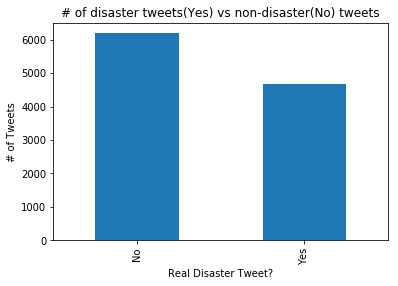

In [69]:
#Let's take a look at the distribution of real disaster tweets vs not real tweets

t = df.groupby('target')

_ = t['target'].count().plot(x='id', y='target', kind='bar')
_ = plt.xlabel ('Real Disaster Tweet?')
_ = plt.ylabel ('# of Tweets')
_ = plt.title('# of disaster tweets(Yes) vs non-disaster(No) tweets')
plt.show()

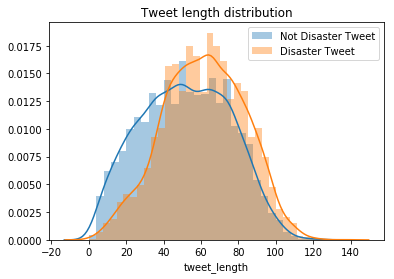

In [70]:
_ = sns.distplot(df[df['target']=='No']['tweet_length']).set_title('Tweet length distribution')
_ = sns.distplot(df[df['target']=='Yes']['tweet_length'])
plt.legend(['Not Disaster Tweet','Disaster Tweet'])
plt.show()

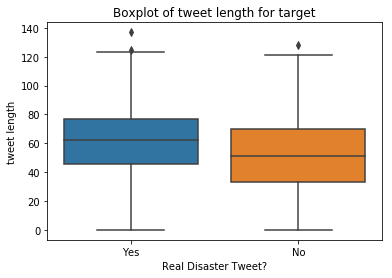

In [71]:
#A look at boxplot of tweet length

_ = sns.boxplot(data=df, x='target', y='tweet_length').set_title('Boxplot of tweet length for target')
_ = plt.xlabel ('Real Disaster Tweet?')
_ = plt.ylabel ('tweet length')
plt.show()

The distribution of disaster tweet lengths are slightly left skewed, while the distribution of non-disaster tweets are slightly right skewed. This could be attributed to the fact that when someone needs to describe a situation, like a disaster, would use more words.


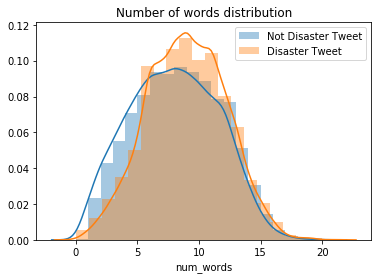

In [72]:
_ = sns.distplot(df[df['target']=='No']['num_words'], bins = 20).set_title('Number of words distribution')
_ = sns.distplot(df[df['target']=='Yes']['num_words'], bins = 20)
plt.legend(['Not Disaster Tweet','Disaster Tweet'])
plt.show()

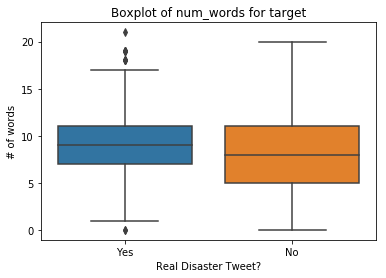

In [73]:
_ = sns.boxplot(data=df, x='target', y='num_words').set_title('Boxplot of num_words for target')
_ = plt.xlabel ('Real Disaster Tweet?')
_ = plt.ylabel ('# of words')
plt.show()

On average, real disaster tweets have more number of words. This makes sense since we saw that tweet length is usually longer for tweets relating to a disaster. The longer the tweet, then it can be assumed that it will have more words. 

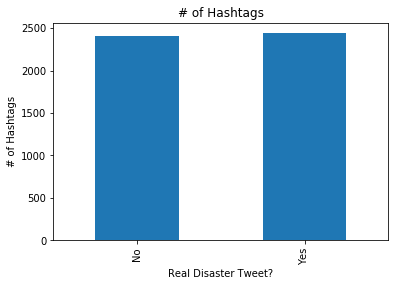

In [74]:
_ = t['hashtag_count'].sum().plot(x='target', y='hashtag_count', kind='bar')
_ = plt.xlabel ('Real Disaster Tweet?')
_ = plt.ylabel ('# of Hashtags')
_ = plt.title('# of Hashtags')
plt.show()

The number of hashtags in each type of tweet is almost identical. I can see how both are helpful in both types of situations. # added before a word or phrase allows that word to be a searchable keyword in twitter. Users can better find posts by looking for certain keywords. 

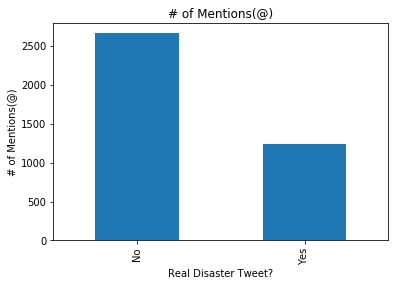

In [75]:
_ = t['mention_count'].sum().plot(x='target', y='mention_count', kind='bar')
_ = plt.xlabel ('Real Disaster Tweet?')
_ = plt.ylabel ('# of Mentions(@)')
_ = plt.title('# of Mentions(@)')
plt.show()

The number of mentions are a lot higher for tweets that are not related to disasters. When users use @ before a username, it tags that person in that post. 

### Text Analysis:

For text analysis, I utilized Frequency Distribution and ngrams from the NLTK library to plot, find most common words, and convert texts to bigrams and trigrams. 

In [76]:
#Create function to combine all tokens in clean_text column into one list

def tokenize_to_list(text):
    allTokens = []
    tokenized = text.apply(word_tokenize)
    for token in tokenized:
        allTokens += token
    return allTokens

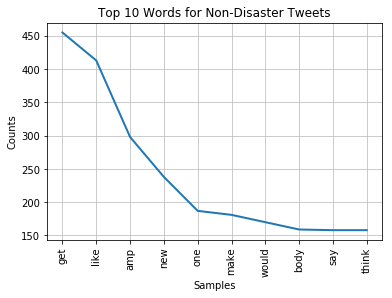

Top 20 Words for Non-Disaster Tweets


[('get', 455),
 ('like', 413),
 ('amp', 298),
 ('new', 238),
 ('one', 187),
 ('make', 181),
 ('would', 170),
 ('body', 159),
 ('say', 158),
 ('think', 158),
 ('love', 155),
 ('see', 154),
 ('time', 151),
 ('bag', 151),
 ('come', 150),
 ('via', 142),
 ('know', 140),
 ('video', 135),
 ('want', 132),
 ('people', 132)]

In [77]:
#Tokens to a single list for No target
allTokens_0 = tokenize_to_list(df[df['target']=='No']['clean_text'])

# Frequency Distribution in NLTK was used in order to find the common words.
fdist_0 = FreqDist(allTokens_0)

#Plot top 10 words
_ = fdist_0.plot(10, title='Top 10 Words for Non-Disaster Tweets')

#Print top 20 words

print('Top 20 Words for Non-Disaster Tweets')
fdist_0.most_common(20)

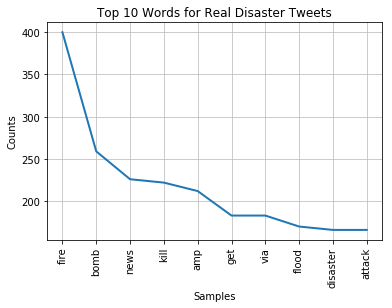

Top 20 Words for Disaster Tweets


[('fire', 400),
 ('bomb', 259),
 ('news', 226),
 ('kill', 222),
 ('amp', 212),
 ('get', 183),
 ('via', 183),
 ('flood', 170),
 ('disaster', 166),
 ('attack', 166),
 ('suicide', 166),
 ('crash', 152),
 ('people', 151),
 ('police', 151),
 ('california', 150),
 ('train', 147),
 ('hiroshima', 146),
 ('like', 146),
 ('home', 137),
 ('storm', 137)]

In [78]:
#Tokens to a single list for Yes target
allTokens_1 = tokenize_to_list(df[df['target']=='Yes']['clean_text'])


fdist_1 = FreqDist(allTokens_1)

_ = fdist_1.plot(10, title='Top 10 Words for Real Disaster Tweets')

print('Top 20 Words for Disaster Tweets')
fdist_1.most_common(20)

The unigram model above displays the most commonly used words in each case of whether a tweet is related to a disaster or not. For disaster tweets, we see the top 2 words that relates to a disaster: “fire” and “bomb”. But seeing just these single words, like the word ‘california’ in the disaster words, it will be hard to categorize the tweet without previously knowing the target.  This is where bigrams and trigrams come in handy because it lists pairs of words that occur together frequently. 

In [79]:
from nltk.util import ngrams

In [80]:
#Create function to apply bigram or trigram to dataframe

def generate_ngrams(text, int):
    """Use dataframe text column in text field. 
    INPUT: 
        - text: DataFrame column
        - int: 2 (for bigram), 3 (for trigram), etc"""
    
    allTokens = []
    
    tokens = text.apply(word_tokenize) #tokenize text
    output = tokens.apply(lambda x: list (ngrams(x, int))) #apply ngrams function
    
    for x in output:
        allTokens += x
    
    return allTokens

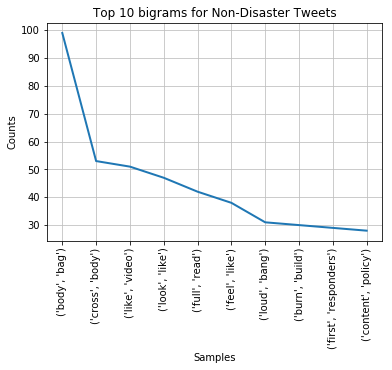

Top 20 Bigrams for Non-Disaster Tweets


[(('body', 'bag'), 99),
 (('cross', 'body'), 53),
 (('like', 'video'), 51),
 (('look', 'like'), 47),
 (('full', 'read'), 42),
 (('feel', 'like'), 38),
 (('loud', 'bang'), 31),
 (('burn', 'build'), 30),
 (('first', 'responders'), 29),
 (('content', 'policy'), 28),
 (('reddit', 'quarantine'), 27),
 (('quarantine', 'offensive'), 27),
 (('china', 'stock'), 27),
 (('stock', 'market'), 27),
 (('market', 'crash'), 27),
 (('emergency', 'service'), 26),
 (('pick', 'fan'), 26),
 (('fan', 'army'), 26),
 (('offensive', 'content'), 26),
 (('prebreak', 'best'), 25)]

In [81]:
#First we will use bigrams

bigram_0 = generate_ngrams(df[df['target']=='No']['clean_text'], 2)

fdist_b0 = FreqDist(bigram_0)

_ = fdist_b0.plot(10, title='Top 10 bigrams for Non-Disaster Tweets')

print('Top 20 Bigrams for Non-Disaster Tweets')
fdist_b0.most_common(20)

In the tweets that are not a disaster, the word “body” and “bag” are common together. This seems odd to me because when I see body and bag together, I assume a bodybag used to place the deceased. 


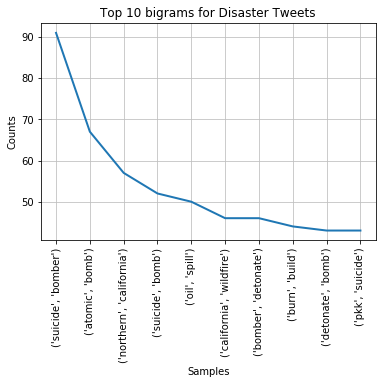

Top 20 Bigrams for Disaster Tweets


[(('suicide', 'bomber'), 91),
 (('atomic', 'bomb'), 67),
 (('northern', 'california'), 57),
 (('suicide', 'bomb'), 52),
 (('oil', 'spill'), 50),
 (('california', 'wildfire'), 46),
 (('bomber', 'detonate'), 46),
 (('burn', 'build'), 44),
 (('detonate', 'bomb'), 43),
 (('pkk', 'suicide'), 43),
 (('wild', 'fire'), 42),
 (('year', 'old'), 41),
 (('old', 'pkk'), 41),
 (('mass', 'murder'), 40),
 (('severe', 'thunderstorm'), 40),
 (('home', 'raze'), 40),
 (('latest', 'home'), 39),
 (('raze', 'northern'), 39),
 (('heat', 'wave'), 36),
 (('bomb', 'turkey'), 36)]

In [82]:
bigram_1 = generate_ngrams(df[df['target']=='Yes']['clean_text'], 2)

fdist_b1 = FreqDist(bigram_1)

_ = fdist_b1.plot(10, title='Top 10 bigrams for Disaster Tweets')

print('Top 20 Bigrams for Disaster Tweets')
fdist_b1.most_common(20)

Bigrams starts to add more context to the different types of tweets. For disaster tweets, we can now see that the unigram word ‘california’ is frequently paired with ‘wildfire’. This makes sense as wildfire disasters have been prevalent in California the past few years. “Raze”, another word for destroy, occurs with home and northern, which when I looked up on Google had a lot of references to wildfires in Northern California that razed houses. ‘PKK’ refers to the Kurdistan Workers Party, who are broadly labeled as terrorists, is frequently paired with ‘suicide’. 

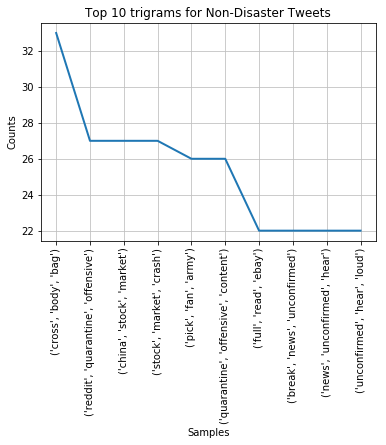

Top 20 Trigrams for Non-Disaster Tweets


[(('cross', 'body', 'bag'), 33),
 (('reddit', 'quarantine', 'offensive'), 27),
 (('china', 'stock', 'market'), 27),
 (('stock', 'market', 'crash'), 27),
 (('pick', 'fan', 'army'), 26),
 (('quarantine', 'offensive', 'content'), 26),
 (('full', 'read', 'ebay'), 22),
 (('break', 'news', 'unconfirmed'), 22),
 (('news', 'unconfirmed', 'hear'), 22),
 (('unconfirmed', 'hear', 'loud'), 22),
 (('hear', 'loud', 'bang'), 22),
 (('loud', 'bang', 'nearby'), 22),
 (('bang', 'nearby', 'appear'), 22),
 (('nearby', 'appear', 'blast'), 22),
 (('appear', 'blast', 'wind'), 22),
 (('blast', 'wind', 'neighbour'), 22),
 (('wind', 'neighbour', 'ass'), 22),
 (('reddit', 'new', 'content'), 22),
 (('new', 'content', 'policy'), 22),
 (('content', 'policy', 'effect'), 21)]

In [83]:
#Create trigrams

trigram_0 = generate_ngrams(df[df['target']=='No']['clean_text'], 3)

fdist_t0 = FreqDist(trigram_0)

_ = fdist_t0.plot(10, title='Top 10 trigrams for Non-Disaster Tweets')

print('Top 20 Trigrams for Non-Disaster Tweets')
fdist_t0.most_common(20)

Looking at a trigram model, we now see that “body” and “bag” in the not disaster tweets had a high occurrence with “cross”, which could refer to a popular handbag; cross body bags. 

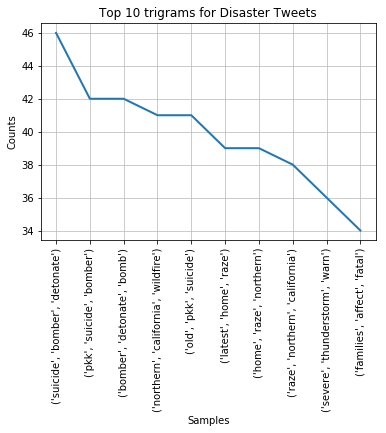

Top 20 Trigrams for Disaster Tweets


[(('suicide', 'bomber', 'detonate'), 46),
 (('pkk', 'suicide', 'bomber'), 42),
 (('bomber', 'detonate', 'bomb'), 42),
 (('northern', 'california', 'wildfire'), 41),
 (('old', 'pkk', 'suicide'), 41),
 (('latest', 'home', 'raze'), 39),
 (('home', 'raze', 'northern'), 39),
 (('raze', 'northern', 'california'), 38),
 (('severe', 'thunderstorm', 'warn'), 36),
 (('families', 'affect', 'fatal'), 34),
 (('affect', 'fatal', 'outbreak'), 34),
 (('watch', 'airport', 'get'), 34),
 (('airport', 'get', 'swallow'), 34),
 (('get', 'swallow', 'sandstorm'), 34),
 (('swallow', 'sandstorm', 'minute'), 34),
 (('detonate', 'bomb', 'turkey'), 34),
 (('bomb', 'turkey', 'army'), 34),
 (('turkey', 'army', 'trench'), 34),
 (('families', 'sue', 'legionnaires'), 33),
 (('wreckage', 'conclusively', 'confirm'), 33)]

In [84]:
trigram_1 = generate_ngrams(df[df['target']=='Yes']['clean_text'], 3)

fdist_t1 = FreqDist(trigram_1)

_ = fdist_t1.plot(10, title='Top 10 trigrams for Disaster Tweets')

print('Top 20 Trigrams for Disaster Tweets')
fdist_t1.most_common(20)

‘California’ and ‘wildfire’ from the bigram model now includes ‘northern’. This gives a better idea to where in California the wildfires may be taking place. One thing noticeable is the count of occurrences. As we increase the models from unigram to bigram to trigram, we see that occurrences of words decrease. I will use all 3 types in my models to see which gives the best results.


# In-Depth Analysis

In [113]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [290]:
features = df[['clean_text','tweet_length', 'num_words','hashtag_count', 'mention_count']]

#Convert target to 1(yes) and 0(no)
Encoder = LabelEncoder()
target = Encoder.fit_transform(target)

In [294]:
print(features.shape, target.shape)

(10860, 5) (10860,)


In [295]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=34)

In [298]:
#Use ColumnTransformer to separate the normalizer for numerical column from text vectors

counts = ['tweet_length', 'num_words','hashtag_count', 'mention_count']

preprocessor = ColumnTransformer( 
    transformers = [('minmax', MinMaxScaler(), counts),
                    ('cv', CountVectorizer(), 'clean_text')],
    remainder='passthrough')

In [325]:
#def model_pipeline(vectorizer, model):
#    """
#    Make a pipeline that transforms text to vectors and rescales numerical columns
#    INPUT:
#        -vectorizer: Choice of vectorizer for your clean text. Example, CountVectorizer()
#        -model: choice of model. Example, LogisticRegression()"""

    
#    counts = ['tweet_length', 'num_words','hashtag_count', 'mention_count']
    
#    preprocess = make_column_transformer((MinMaxScaler(), counts),
#                                        (vectorizer, 'clean_text'))

    
#    pipeline = make_pipeline(preprocess, model)
    
#    return pipeline

### Baseline Model

In [375]:
dummy = make_pipeline(preprocessor, DummyClassifier(random_state=34))
dummy_score = dummy.fit(X_train, y_train).score(X_test,y_test)

print ('Baseline Model Accuracy for CountVectorizer: %.3f' % dummy_score)

Baseline Model Accuracy for CountVectorizer: 0.505


### Logistic Regression

Model Score on Train: 0.941
Model Score on Test: 0.794
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1848
           1       0.80      0.70      0.75      1410

    accuracy                           0.79      3258
   macro avg       0.79      0.78      0.79      3258
weighted avg       0.79      0.79      0.79      3258



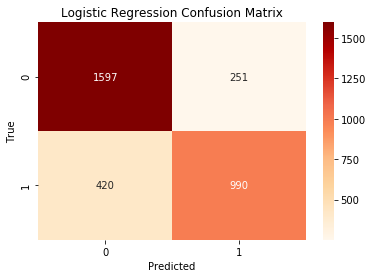

CPU times: user 1.18 s, sys: 97.2 ms, total: 1.28 s
Wall time: 784 ms


In [338]:
%%time

lr_pipe = make_pipeline(preprocessor, LogisticRegression(random_state=34))

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)
print('Model Score on Train: %.3f' % lr_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % lr_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('Logistic Regression Confusion Matrix')
plt.show()


### Decision Tree Classifier

In [376]:
#Normalizaiton for Decision Tree and Random Forest is not needed

cv = make_column_transformer((CountVectorizer(), 'clean_text'), remainder='passthrough')

Model Score on Train: 0.986
Model Score on Test: 0.743
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1848
           1       0.73      0.65      0.69      1410

    accuracy                           0.74      3258
   macro avg       0.74      0.73      0.73      3258
weighted avg       0.74      0.74      0.74      3258



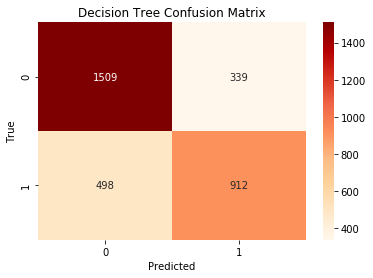

CPU times: user 2 s, sys: 73 ms, total: 2.08 s
Wall time: 1.97 s


In [377]:
%%time

dt_pipe = make_pipeline(cv, DecisionTreeClassifier(random_state=34))

dt_pipe.fit(X_train, y_train)

y_pred = dt_pipe.predict(X_test)
print('Model Score on Train: %.3f' % dt_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % dt_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('Decision Tree Confusion Matrix')
plt.show()

### Random Forest Classifier

Model Score on Train: 0.986
Model Score on Test: 0.785
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1848
           1       0.84      0.63      0.72      1410

    accuracy                           0.79      3258
   macro avg       0.80      0.77      0.77      3258
weighted avg       0.79      0.79      0.78      3258



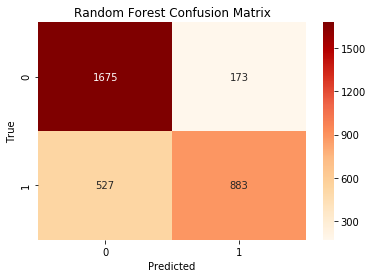

CPU times: user 15.2 s, sys: 157 ms, total: 15.4 s
Wall time: 15.7 s


In [341]:
%%time

rf_pipe = make_pipeline(cv, RandomForestClassifier(random_state=34))
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print('Model Score on Train: %.3f' % rf_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % rf_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('Random Forest Confusion Matrix')
plt.show()

### AdaBoost Classifier

Model Score on Train: 0.755
Model Score on Test: 0.731
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      1848
           1       0.79      0.52      0.62      1410

    accuracy                           0.73      3258
   macro avg       0.75      0.71      0.71      3258
weighted avg       0.74      0.73      0.72      3258



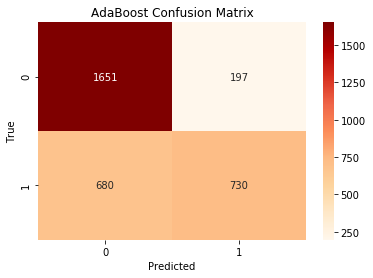

CPU times: user 1.59 s, sys: 76.7 ms, total: 1.66 s
Wall time: 1.66 s


In [343]:
%%time

ada_pipe = make_pipeline(preprocessor, AdaBoostClassifier(random_state=34))

ada_pipe.fit(X_train, y_train)
y_pred = ada_pipe.predict(X_test)
print('Model Score on Train: %.3f' % ada_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % ada_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('AdaBoost Confusion Matrix')
plt.show()

### Gradient Boost Classifier

Model Score on Train: 0.780
Model Score on Test: 0.751
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      1848
           1       0.86      0.51      0.64      1410

    accuracy                           0.75      3258
   macro avg       0.79      0.72      0.72      3258
weighted avg       0.78      0.75      0.74      3258



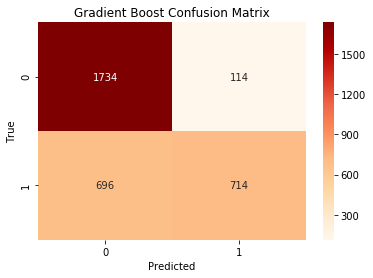

CPU times: user 2.79 s, sys: 108 ms, total: 2.9 s
Wall time: 3.07 s


In [344]:
%%time

gb_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=34))

gb_pipe.fit(X_train, y_train)
y_pred = gb_pipe.predict(X_test)
print('Model Score on Train: %.3f' % gb_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % gb_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('Gradient Boost Confusion Matrix')
plt.show()

### SVC

Model Score on Train: 0.941
Model Score on Test: 0.802
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1848
           1       0.85      0.65      0.74      1410

    accuracy                           0.80      3258
   macro avg       0.81      0.78      0.79      3258
weighted avg       0.81      0.80      0.80      3258



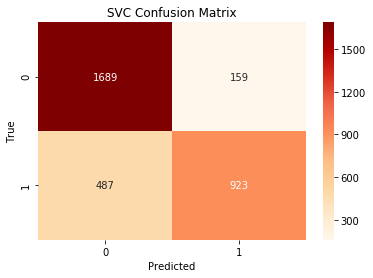

CPU times: user 16.3 s, sys: 335 ms, total: 16.6 s
Wall time: 17 s


In [345]:
%%time

svc_pipe = make_pipeline(preprocessor, SVC(random_state=34))

svc_pipe.fit(X_train, y_train)
y_pred = svc_pipe.predict(X_test)
print('Model Score on Train: %.3f' % svc_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % svc_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('SVC Confusion Matrix')
plt.show()

### KNN

Model Score on Train: 0.822
Model Score on Test: 0.735
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1848
           1       0.80      0.51      0.63      1410

    accuracy                           0.74      3258
   macro avg       0.76      0.71      0.71      3258
weighted avg       0.75      0.74      0.72      3258



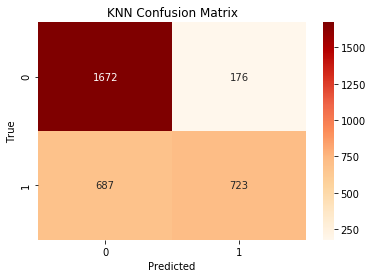

CPU times: user 5.68 s, sys: 1.91 s, total: 7.59 s
Wall time: 8.35 s


In [346]:
%%time

knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print('Model Score on Train: %.3f' % knn_pipe.score(X_train,y_train))
print('Model Score on Test: %.3f' % knn_pipe.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('KNN Confusion Matrix')
plt.show()

Logistic Regression, Random Forest Classifier, and SVC models have the highest accuracy and f1 scores. 

### Dimension Reduction

In [372]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = PCA(n_components=0.95, random_state=34)
svd = TruncatedSVD(n_components=0.95, random_state=34)

In [373]:
test = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=0.95, random_state=34))

In [374]:
%%time

lr_pipe_pca = make_pipeline(preprocessor, svd, LogisticRegression(random_state=34))

lr_pipe_pca.fit(X_train, y_train)

y_pred = lr_pipe_pca.predict(X_test)
print('Model Score on Train: %.3f' % lr_pipe_pca.score(X_train,y_train))
print('Model Score on Test: %.3f' % lr_pipe_pca.score(X_test, y_test))
print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred)
_ = sns.heatmap(conf, annot=True, fmt='d', cmap='OrRd')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('True')
_ = plt.title('Logistic Regression w/ PCA Confusion Matrix')
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
%%time

cv_pca_train = PCA(n_components=0.95, random_state=34).fit(X_train)
cv_pca_test = PCA(n_components=0.95, random_state=34).fit(X_test)

In [ ]:
_ = plt.plot(np.cumsum(cv_pca_train.explained_variance_ratio_))
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Variance (%)')
_ = plt.title('CountVectorizer Dataset Explained Variance')
plt.show()